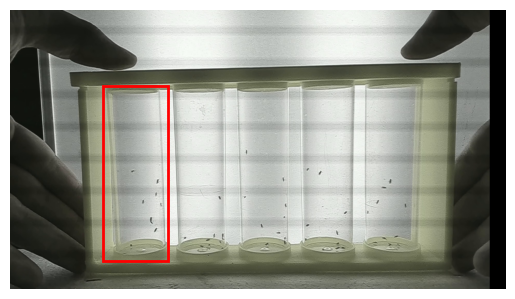

In [1]:
import imageio
import skimage
from skimage import color, io, filters
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import trackpy as tp
import numpy as np
import pandas as pd

# Video file name
video_file = 'Marko Medicinski nonFX/K1mM2/k1mM_S7_2024-06-19 13-02-49.mkv'
csv_file = 'Marko Medicinski nonFX/K1mM2/k1mM_S7_2024-06-19 13-02-49.csv'
#video_file = "mp4 snimci/G2 mp4/G2 S1 2024-03-28 12-40-57.mp4"
#csv_file = "mp4 snimci/G2 mp4/G2 S1 2024-03-28 12-40-57.csv"
#video_file = "Tura Milano/S6 FX 2024-05-16 14-11-14.mkv"
#csv_file = "Tura Milano/S6 FX 2024-05-16 14-11-14.csv"
roi_data = pd.read_csv(csv_file)
first_frame_no = roi_data['First frame'][0]
last_frame_no = roi_data['Last frame'][0]
fly_count = roi_data['Fly Number'][0]

# Read video
video_reader = imageio.get_reader(video_file)
first_frame = video_reader.get_data(first_frame_no)
duration = video_reader.get_meta_data()['fps'] * 30

# Plot the first frame with a red rectangle
fig, ax = plt.subplots()
ax.imshow(first_frame)
ax.axis('off')

for index, row in roi_data.iterrows():
    if index == 1: break
    s = 1 #0.28125
    x_roi = round(row['Top Left X']/s)
    y_roi = round(row['Top Left Y']/s)
    width_roi = round(row['Bottom Right X']/s - x_roi)
    height_roi = round(row['Bottom Right Y']/s - y_roi)
    rect = patches.Rectangle((x_roi, y_roi), width_roi, height_roi, linewidth=2, edgecolor='red', facecolor='none')
    ax.add_patch(rect)
plt.show()

In [3]:
# CROP
image_stack = []
for br, frame in enumerate(video_reader):
    if br < first_frame_no:
        continue
    if br == first_frame_no + duration:
        break
    frameShrink = frame[y_roi:y_roi+height_roi, x_roi:x_roi+width_roi]
    image_stack.append(color.rgb2gray(frameShrink))
    print(br)

image_stack = np.stack(image_stack)
frame_count = image_stack.shape[0]

308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407


In [4]:
# DEFLICKER
soft_low = 30
soft_high = 40 

cuvalica = image_stack.copy()
prev_luminance_avg = 0
br = 0
a = 0.9     
for br in range(1,frame_count):
    frame = image_stack[br, :, :]
    prev_frame = image_stack[br-1, :, :]
    luminance_avg = np.mean(frame)

    if abs(1 - prev_luminance_avg / luminance_avg) > (1 - a):
        prev_luminance_avg = luminance_avg
    else:  
        scale = a + (1 - a) * prev_luminance_avg / luminance_avg 
        adjusted_frame = np.clip(frame * scale, 0, 1)
        luminance_avg = np.mean(adjusted_frame)

        soft_low  = 0.05 * luminance_avg
        soft_high = 0.10 * luminance_avg
        diff = abs(prev_frame - adjusted_frame)
        mask = np.logical_and(diff > soft_low, diff < soft_high)
        final = adjusted_frame.copy()
        
        final[mask] = (adjusted_frame[mask] * 2 + prev_frame[mask]) / 3

        mask = (diff <= soft_low)
        final[mask] = prev_frame[mask]

        image_stack[br, :, :] = final.copy()

    print(br)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [72]:
import os
import numpy as np
import matplotlib.pyplot as plt

image_stack = (image_stack * 255).astype(np.uint8)
# Create the directory if it doesn't exist
save_dir = 'Test/detection/'
os.makedirs(save_dir, exist_ok=True)

random_frame = image_stack[np.random.randint(0, frame_count),:,:]

median_frame = np.median(image_stack, axis=0)
max_frame = np.max(image_stack, axis=0)
min_frame = np.min(image_stack, axis=0)

# Save the max_frame, median_frame, and image_stack
np.save(os.path.join(save_dir, 'max_frame.npy'), max_frame)
np.save(os.path.join(save_dir, 'median_frame.npy'), median_frame)
np.save(os.path.join(save_dir, 'image_stack.npy'), image_stack)
np.save(os.path.join(save_dir, 'min_frame.npy'), min_frame)


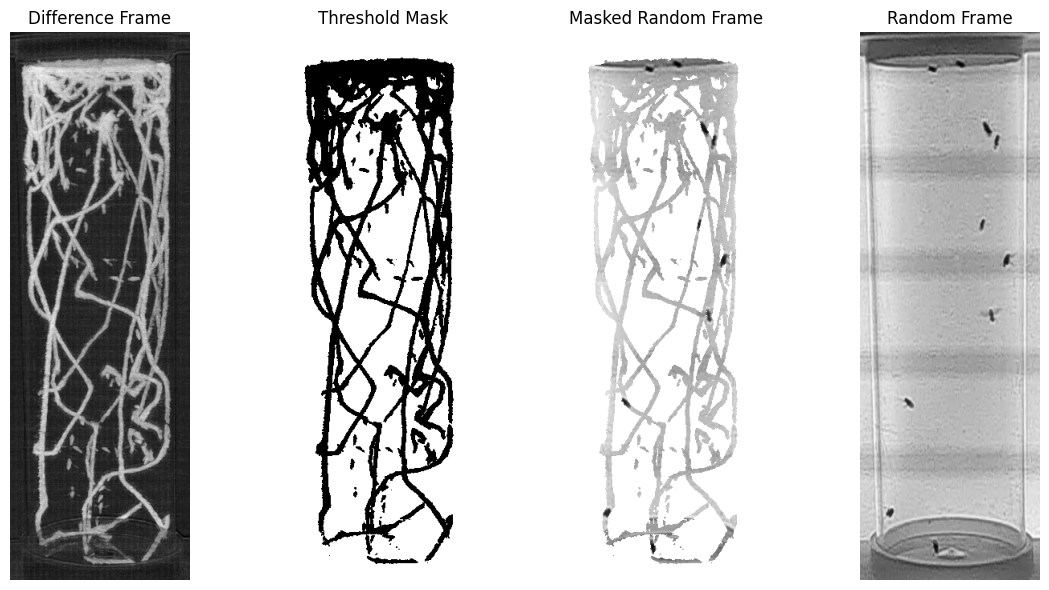

In [69]:
dif_frame = max_frame - min_frame

from skimage.filters import threshold_otsu# Apply a threshold on dif_frame to create a binary mask
threshold_value = threshold_otsu(dif_frame)  # Use median value as the threshold
mask = dif_frame < threshold_value  # Binary mask where values are above the threshold

# Create an output frame where we apply the mask to random_frame
output_frame = random_frame.copy()  # Copy random_frame to modify
output_frame[mask] = 255  # Set white (255) where mask is True

# Plot the original dif_frame, mask, and final output
plt.figure(figsize=(12, 6))

# Display dif_frame
plt.subplot(1, 4, 1)
plt.imshow(dif_frame, cmap='gray')
plt.title('Difference Frame')
plt.axis('off')

# Display the mask
plt.subplot(1, 4, 2)
plt.imshow(mask, cmap='gray')
plt.title('Threshold Mask')
plt.axis('off')

# Display the output frame where mask is applied
plt.subplot(1, 4, 3)
plt.imshow(output_frame, cmap='gray')
plt.title('Masked Random Frame')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(random_frame, cmap='gray')
plt.title('Random Frame')
plt.axis('off')

plt.tight_layout()
plt.show()
